# Brief disclaimer and where the data comes from
___
**Disclaimer:** In order to keep the anonymity of the participants that completed the survey I have executed the following lines of code beforehand (thus eliminating their personal emails) ensuring the protection of personal data according to local law. Other than that small change, the data remains the same.

```python
import pandas as pd

fpath = (r"C:\survey.csv")
df = pd.read_csv(fpath, sep = ";", encoding = "ANSI")

email = df.columns[-1]
df = df.drop(columns = [email])

df.to_csv("anonymized.csv", sep = ";", index = False, encoding = "ANSI")
```

**Where the data comes from?** I work at an university (Universidad de la República, Uruguay) which has a Latinamerican model of university, this means we have three core tenets to uphold : a) Research, b) Teaching, c) Outreach. The last one has evolved in the last few decades from being the university that has the knowledge and provides it to the society, to be something more complex where knoweldge is produced in situ by both the university and the society according to the problematic faced by the society. As such, this data is part of a small research looking to find out what students from the psychology undergrad understand by outreach, if they think that the syllabus is clear about outreach and if it provides enough opportunities to pursue an academic formation around outreach.

### Survey details:
Here is a brief dictionary which shows the column names I'm going to use (once I rename them) with the survey question in case you wonder what was the survey about. Also, I leave some specifications about the survey that might answer most questions.

```python
dic = {
    "gender" : "Please, specify your gender",
    "date_of_birth": "Please, choose your date of birth",
    "undergrad_advancement" : "How far are you on your Psychology undergrad?",
    "undergrad_loc" : "In which campus are you taking your undergrad?",
    "q1" : "Has any particular class peaked your interest to find out more about outreach?",
    "q1_cont" : "Please name the class or classes",
    "q2" : "Do you know about other opportunities to develop your carreer around outreach in the university?",
    "q2_cont" : "Please name them",
    "q3" : "Have you been part of an outreach student project before?",
    "q3_cont" : "How do you evaluate your experience?",
    "q4" : "Have you taken part in EFIs?",
    "q4_cont" : "What motivated you to take part in them?",
    "q4_cont2" : "How do you evaluate your experience?",
    "q5" : "I think the theoretical aspects taught about outreach have been useful in outreach related experiences (e.g.: internships, field jobs, etc.)",
    "q6" : "I have been able to articulate theory with practice in outreach related experiences (e.g.: internships, field jobs, etc.)",
    "q7" : "While doing outreach, I usually find myself facing ethical dilemmas",
    "q8" : "Do you think the current syllabus allows you to take enough outreach related classes?",
    "q9" : "Do you feel confident about writing your undergrad thesis in the outreach modality?",
    "q9_cont" : "Please indicate how willing are you to choose this modality over the others",
    "focus_group" : "Are you willing and able to partake in a Zoom focus group?"
}
```
___
#### Specifications: 
**Gender:** The options where "Man", "Woman" or a blank space to specify. 
**Date of birth:** A calendar was shown in which the participant could indicate their date of birth.
**Undergrad advancement and location:** Both had listed options to choose from. Undergrad advancement options were a) "Ciclo Inicial" which refers to Freshmen and Freshwomen, b) "Ciclo de Formación Integral" to refer to Sophomores and Juniors, c) "Ciclo de Graduación" for Seniors. In the same way, the university offers the undergrand throught the country in three campuses: 1) In the capital of the country (Montevideo) abbreviated "FPsico" (short for "Facultad de Psicología"), 2) In the city of Salto (if you like soccer, you may know the players Luis Suarez and Edinson Cavani both hail from this city), 3) In the city of Paysandú. The last two are abbreviated CENUR (short for "Centro Universitario Regional") plus their respective city.
**Questions 1, 2, 3, 4, 8 and 9:** Answer options were "Yes", "No", "I don't know" (this last option was not available in questions 2 and 3).
**Questions 5, 6, 7:** Likert scale was used (from 1 for "Completely disagree" to 5 "Completely agree").
**All answers were mandatory except the follow up questions (cont)**. Follow up to questions 1, 2 and 4 were long answer type of questions (open ended). Follow up for the other questions (q3_cont, q4_cont2, q9_cont) used Likert scale (from 1 for "Very negative" to 5 "Very positive"). Also, this follow up questions would display only if the participant answered affirmatively the previous questions (e.g.: q1_cont would display after answering "Yes" to q1 only).
**EFIs:** This are field lessons where students put into practice the outreach tenet with teacher supervision.
___

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Feb 15 17:21:46 2021

@author: Ignacio
"""
# 1. Import libraries to use.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords



# 2. Create functions.
def pretty(obj):
    """
    Takes a python like object (ie: a dictionary) and 'pretty prints'
    it into human readable format.
    
    Important: 
    Python pprint module needs to be imported for this function to 
    work. Also, dictionaries are NOT sorted when this functions is
    applied to a dictionary.
    """
    
    pp = pprint.PrettyPrinter(indent = 2, sort_dicts = False)
    return pp.pprint(obj)


def disp(df, nrows = 30, ncolumns = 100):
    """
    Takes in a Data Frame and displays 50 rows and 100 columns
    by changing Pandas options for the invocation only. This avoids 
    having to always change back and forth Pandas settings when checking
    multiple rows/columns.
    """
    
    with pd.option_context("display.min_rows", nrows, "display.max_columns",
                           ncolumns): display(df)

        
def combine_rows (df, col, nan_col = "id"):
    """
    Identifies cases where str data 'spills over' to other rows,
    adds that spilled over data to the original case.
    
    E.G.: If rows 21 and 22 have str data from participant in row
    20 the function first identifies 'spilled' rows (21 & 22),
    then the participant (row 20), marks the affected range (20-22)
    and uses .str.cat to combine the information in the participant
    row (row 20 now has the data from row 21 and 22).
    
    Parameters:
    df: affected dataframe
    col: column with spilled over str data
    nan_col: spilled rows leave NaN values in other columns, uses
    'id' as default column
    """
    
    # Identifies affected rows:
    flter = (df[nan_col].isnull()) & (df[col].notnull())
    nan_idx = df.index[flter].tolist()
    # Identifies the cases that the data belongs to:
    case_idx = [i-1 for i in nan_idx if i-1 not in nan_idx]
    # Combines both lists and sorts the final list:
    nan_idx += case_idx
    nan_idx.sort() 
    # Marks the range and creates lower bound (lb)
    # and upper bound + 1 (ub) lists:
    limits_idx = [i for i in nan_idx if (i-1 not in nan_idx) or (i+1 not in nan_idx)] 
    lower_bound_ls = []
    upper_bound_ls = []
    i = 0
    while i != len(limits_idx):
        if i%2 == 0:
            lower_bound_ls.append(limits_idx[i])
        else:
            upper_bound_ls.append(limits_idx[i]+1)
        i += 1
    # Copies spilled data and adds it to the corresponding case
    for (lb, ub) in zip(lower_bound_ls, upper_bound_ls):
        df[col].iloc[lb:ub] = df[col].iloc[lb:ub].str.cat(sep = ", ") 

In [2]:
# 3. Import data, create Data Frame and make a copy to work with
# (thus avoiding altering the original dataset).    
fpath = (r"C:\anonymized.csv")

original_df = pd.read_csv(fpath, sep = ";", encoding = "ANSI")
working_df = original_df.copy()


# 4. Exploratory Data Analysis (EDA).
# 4.1. Check the dataframe to see what kind of data we are working with:
print("(columns, rows):")
print(working_df.shape)
display(working_df.head(25))
display(working_df.tail())
print("---- Column names:")
print(working_df.columns)
print("\n---- Column dtypes:")
print(working_df.dtypes)

(columns, rows):
(331, 22)


,Serial number,Created,Género,¿Cuál es tu fecha de nacimiento?,"Actualmente, ¿ cuál es tu grado de avance en la Licenciatura en Psicología?",¿En qué servicio estás cursando la carrera actualmente?,"1. ¿Algún curso (UCO, optativo, práctica, etc.) ha fomentado tu interés en la extensión?",Por favor indica cuál,2. ¿Conoces otros espacios en la Facultad de Psicología que te permitan desarrollar una formación en extensión?,Menciona alguno de ellos,...,4. ¿Has participado en Espacios de formación integral (EFI)?,¿Qué te llevó a postularte?,¿Cómo evalúas la experiencia?.1,5. Considero que los aportes teóricos y metodológicos adquiridos sobre Extensión (según mi avance curricular) me permitieron desenvolverme adecuadamente en experiencias de extensión,"6. Participando de una experiencia de extensión, he logrado artícular los conocimientos teóricos con la práctica",7. Consideras que las experiencias de extensión son instancias que te llevan a cuestionarte aspectos éticos,8. ¿Consideras que el plan actual (PELP 2013) te permite armar tu itinerario/cursada alrededor de la extensión?,9. ¿Te parece viable realizar este proyecto solo?,Qué tan dispuesto estarías a realizarlo por sobre las otras modalidades de TFG,¿Estarías dispuesto a participar de un grupo focal vía Zoom?
0,3.0,2020-11-18 21:18:24,Hombre,1981-11-23,Ciclo de Formación Integral,Facultad de Psicología,No,NaN,No,NaN,...,No,NaN,NaN,3.0,3.0,3.0,No se,No,NaN,Si
1,4.0,2020-11-18 22:31:20,Mujer,1997-06-24,Ciclo de Graduación,Facultad de Psicología,Si,EFI Extensión Rural y Tutorías entre Pares,No,NaN,...,Si,La experiencia de trabajo interdisciplinario y...,4.0,4.0,5.0,3.0,No,No,NaN,Si
2,5.0,2020-11-19 08:04:24,Mujer,1983-10-21,Ciclo de Formación Integral,Facultad de Psicología,Aún no tengo del todo claro qué es la Extensión,NaN,No,NaN,...,No,NaN,NaN,2.0,2.0,4.0,No,No,NaN,No
3,6.0,2020-11-19 08:04:59,Mujer,1978-10-27,Ciclo de Formación Integral,Facultad de Psicología,No,NaN,No,NaN,...,No,NaN,NaN,3.0,1.0,4.0,No,No se,NaN,No
4,7.0,2020-11-19 08:05:02,Mujer,1985-06-26,Ciclo de Graduación,Facultad de Psicología,Si,"Salud sexual, reproductiva y perinatal",No,NaN,...,No,NaN,NaN,3.0,4.0,3.0,No,No se,NaN,No
5,8.0,2020-11-19 08:05:02,Hombre,1973-09-07,Ciclo Inicial,Facultad de Psicología,Si,Articulacion de Saberes,No,NaN,...,No se que es un Espacio de Formación Integral ...,NaN,NaN,5.0,5.0,5.0,No se,Si,5.0,Si
6,9.0,2020-11-19 08:08:11,Mujer,2001-03-20,Ciclo Inicial,Facultad de Psicología,No,NaN,No,NaN,...,No,NaN,NaN,1.0,1.0,3.0,No se,No se,NaN,No
7,10.0,2020-11-19 08:08:54,Mujer,1998-01-19,Ciclo de Formación Integral,Facultad de Psicología,No,NaN,No,NaN,...,No,NaN,NaN,2.0,1.0,5.0,No,No,NaN,Si
8,11.0,2020-11-19 08:10:52,Mujer,2000-01-28,Ciclo de Formación Integral,Facultad de Psicología,No,NaN,No,NaN,...,Si,"El acercamiento al campo, vivir una experienci...",5.0,2.0,3.0,4.0,No,No se,NaN,Si
9,12.0,2020-11-19 08:14:57,Mujer,1999-07-02,Ciclo de Formación Integral,Facultad de Psicología,Si,Prácticas en centros de primera infancia,No,NaN,...,No,NaN,NaN,4.0,3.0,2.0,No se,Si,3.0,Si


,Serial number,Created,Género,¿Cuál es tu fecha de nacimiento?,"Actualmente, ¿ cuál es tu grado de avance en la Licenciatura en Psicología?",¿En qué servicio estás cursando la carrera actualmente?,"1. ¿Algún curso (UCO, optativo, práctica, etc.) ha fomentado tu interés en la extensión?",Por favor indica cuál,2. ¿Conoces otros espacios en la Facultad de Psicología que te permitan desarrollar una formación en extensión?,Menciona alguno de ellos,...,4. ¿Has participado en Espacios de formación integral (EFI)?,¿Qué te llevó a postularte?,¿Cómo evalúas la experiencia?.1,5. Considero que los aportes teóricos y metodológicos adquiridos sobre Extensión (según mi avance curricular) me permitieron desenvolverme adecuadamente en experiencias de extensión,"6. Participando de una experiencia de extensión, he logrado artícular los conocimientos teóricos con la práctica",7. Consideras que las experiencias de extensión son instancias que te llevan a cuestionarte aspectos éticos,8. ¿Consideras que el plan actual (PELP 2013) te permite armar tu itinerario/cursada alrededor de la extensión?,9. ¿Te parece viable realizar este proyecto solo?,Qué tan dispuesto estarías a realizarlo por sobre las otras modalidades de TFG,¿Estarías dispuesto a participar de un grupo focal vía Zoom?
326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hospital Vilardebo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,APEX Cerro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,La Unión,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Minas Lavalleja,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---- Column names:
Index(['Serial number', 'Created', 'Género',
       '¿Cuál es tu fecha de nacimiento?',
       'Actualmente, ¿ cuál es tu grado de avance en la Licenciatura en Psicología?',
       '¿En qué servicio estás cursando la carrera actualmente?',
       '1. ¿Algún curso (UCO, optativo, práctica, etc.) ha fomentado tu interés en la extensión?',
       'Por favor indica cuál',
       '2. ¿Conoces otros espacios en la Facultad de Psicología que te permitan desarrollar una formación en extensión?',
       'Menciona alguno de ellos',
       '3. ¿Has participado en proyectos estudiantiles de extensión?',
       '¿Cómo evalúas la experiencia?',
       '4. ¿Has participado en Espacios de formación integral (EFI)?',
       '¿Qué te llevó a postularte?', '¿Cómo evalúas la experiencia?.1',
       '5. Considero que los aportes teóricos y metodológicos adquiridos sobre Extensión (según mi avance curricular) me permitieron desenvolverme adecuadamente en experiencias de extensión',
      

At first glance **the dataframe seems quite messy** with rows without a "Serial number" (ID). By checking these rows, the cause behind this seems to be the "long answer" type of questions, **in some cases these answers occupy multiple rows but are related to the same participant** (check row 20-22, Serial number 23). Also, **the columns names are the survey questions itself** which would be quite akward to work with. Since the columns need to be renamed to make it easier to work with, I might as well rename them in English to make the dataframe more PEP8 compliant. Lastly, **dtypes seem to be anything but what you expect** ("Serial number" is float instead of integer and the same happens with other discrete values). Let's start by renaming the columns and afterwards we can dive into cleaning the dataframe. I'm going to short name "question" as "q".

In [3]:
col_names = [
    "id", "date", "gender", "birthdate", "undergrad_advancement","undergrad_loc", 
    "q1", "q1_cont", "q2", "q2_cont", "q3", "q3_cont", "q4",
    "q4_cont", "q4_cont2", "q5", "q6", "q7", "q8", "q9", "q9_cont", 
    "focus_group"
    ]

# Make a simple test to check there are no columns missing in "col_names":
print("The quantity of items in col_names and in the DF are the same:")
print(len(col_names) == len(list(working_df.columns)))

The quantity of items in col_names and in the DF are the same:
True


In [4]:
# Since everything is ok, let's rename the columns:
new_col_names = {k: v for (k, v) in zip(working_df.columns[:-1], col_names)}
working_df = working_df.rename(new_col_names, axis = 1)

# Now we can check the renaming, and as a plus, we have each column name
# associated with the survey question in the "new_col_names" variable, so we
# can just print that in case we forget what question was "q8" (for example).
# The drawback is that is in spanish, but I left a dictionary in the beginning
# (in english) for any English speaker as well as specifications about the survey.

print(pretty(new_col_names))
print("\n")
print(working_df.columns)

{ 'Serial number': 'id',
  'Created': 'date',
  'Género': 'gender',
  '¿Cuál es tu fecha de nacimiento?': 'birthdate',
  'Actualmente, ¿ cuál es tu grado de avance en la Licenciatura en Psicología?': 'undergrad_advancement',
  '¿En qué servicio estás cursando la carrera actualmente?': 'undergrad_loc',
  '1. ¿Algún curso (UCO, optativo, práctica, etc.) ha fomentado tu interés en la extensión?': 'q1',
  'Por favor indica cuál': 'q1_cont',
  '2. ¿Conoces otros espacios en la Facultad de Psicología que te permitan desarrollar una formación en extensión?': 'q2',
  'Menciona alguno de ellos': 'q2_cont',
  '3. ¿Has participado en proyectos estudiantiles de extensión?': 'q3',
  '¿Cómo evalúas la experiencia?': 'q3_cont',
  '4. ¿Has participado en Espacios de formación integral (EFI)?': 'q4',
  '¿Qué te llevó a postularte?': 'q4_cont',
  '¿Cómo evalúas la experiencia?.1': 'q4_cont2',
  '5. Considero que los aportes teóricos y metodológicos adquiridos sobre Extensión (según mi avance curricular)

In [5]:
# 4.2. Cleaning Data.
# Now we need to solve the issue related to the "long answer" questions,
# namely q1_cont, q2_cont and q4_cont. To solve this problem I made
# the "combine_rows" function (see above in point 2 for an explanation).
# Afterwards it will be safe to delete those rows. As an extra, this
# will also delete any rows with all NaN values since all NaN values
# includes "id". 
cont_cols = ['q1_cont', 'q2_cont', 'q4_cont']
for col in cont_cols:
    combine_rows (working_df, col)

working_df = working_df.dropna(subset = ["id"])
# Checking everything is in order:
display(working_df.head(25))
display(working_df.tail())

C:\Users\Ignacio\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,id,date,gender,birthdate,undergrad_advancement,undergrad_loc,q1,q1_cont,q2,q2_cont,...,q4,q4_cont,q4_cont2,q5,q6,q7,q8,q9,q9_cont,¿Estarías dispuesto a participar de un grupo focal vía Zoom?
0,3.0,2020-11-18 21:18:24,Hombre,1981-11-23,Ciclo de Formación Integral,Facultad de Psicología,No,NaN,No,NaN,...,No,NaN,NaN,3.0,3.0,3.0,No se,No,NaN,Si
1,4.0,2020-11-18 22:31:20,Mujer,1997-06-24,Ciclo de Graduación,Facultad de Psicología,Si,EFI Extensión Rural y Tutorías entre Pares,No,NaN,...,Si,La experiencia de trabajo interdisciplinario y...,4.0,4.0,5.0,3.0,No,No,NaN,Si
2,5.0,2020-11-19 08:04:24,Mujer,1983-10-21,Ciclo de Formación Integral,Facultad de Psicología,Aún no tengo del todo claro qué es la Extensión,NaN,No,NaN,...,No,NaN,NaN,2.0,2.0,4.0,No,No,NaN,No
3,6.0,2020-11-19 08:04:59,Mujer,1978-10-27,Ciclo de Formación Integral,Facultad de Psicología,No,NaN,No,NaN,...,No,NaN,NaN,3.0,1.0,4.0,No,No se,NaN,No
4,7.0,2020-11-19 08:05:02,Mujer,1985-06-26,Ciclo de Graduación,Facultad de Psicología,Si,"Salud sexual, reproductiva y perinatal",No,NaN,...,No,NaN,NaN,3.0,4.0,3.0,No,No se,NaN,No
5,8.0,2020-11-19 08:05:02,Hombre,1973-09-07,Ciclo Inicial,Facultad de Psicología,Si,Articulacion de Saberes,No,NaN,...,No se que es un Espacio de Formación Integral ...,NaN,NaN,5.0,5.0,5.0,No se,Si,5.0,Si
6,9.0,2020-11-19 08:08:11,Mujer,2001-03-20,Ciclo Inicial,Facultad de Psicología,No,NaN,No,NaN,...,No,NaN,NaN,1.0,1.0,3.0,No se,No se,NaN,No
7,10.0,2020-11-19 08:08:54,Mujer,1998-01-19,Ciclo de Formación Integral,Facultad de Psicología,No,NaN,No,NaN,...,No,NaN,NaN,2.0,1.0,5.0,No,No,NaN,Si
8,11.0,2020-11-19 08:10:52,Mujer,2000-01-28,Ciclo de Formación Integral,Facultad de Psicología,No,NaN,No,NaN,...,Si,"El acercamiento al campo, vivir una experienci...",5.0,2.0,3.0,4.0,No,No se,NaN,Si
9,12.0,2020-11-19 08:14:57,Mujer,1999-07-02,Ciclo de Formación Integral,Facultad de Psicología,Si,Prácticas en centros de primera infancia,No,NaN,...,No,NaN,NaN,4.0,3.0,2.0,No se,Si,3.0,Si


,id,date,gender,birthdate,undergrad_advancement,undergrad_loc,q1,q1_cont,q2,q2_cont,...,q4,q4_cont,q4_cont2,q5,q6,q7,q8,q9,q9_cont,¿Estarías dispuesto a participar de un grupo focal vía Zoom?
320,276.0,2020-12-29 02:34:18,Mujer,1974-01-06,Ciclo de Formación Integral,Facultad de Psicología,No,NaN,No,NaN,...,No,NaN,NaN,3.0,3.0,4.0,No se,No se,NaN,No
321,277.0,2021-01-11 21:58:18,Mujer,1989-01-20,Ciclo de Graduación,Facultad de Psicología,Si,Practicas de psicologos en Inau,No,NaN,...,No,NaN,NaN,3.0,4.0,5.0,No se,Si,3.0,Si
322,278.0,2021-01-13 01:03:53,Mujer,1967-04-15,Ciclo de Formación Integral,Facultad de Psicología,Aún no tengo del todo claro qué es la Extensión,NaN,No,NaN,...,Si,avanzar en la carrera,4.0,4.0,4.0,5.0,No se,No se,NaN,Si
323,279.0,2021-01-22 02:46:16,Hombre,1993-09-03,Ciclo de Formación Integral,Facultad de Psicología,No,NaN,No,NaN,...,Si,contacto con el campo,4.0,3.0,3.0,5.0,No,No se,NaN,Si
324,280.0,2021-01-29 10:19:10,Hombre,1964-01-27,Ciclo de Graduación,Facultad de Psicología,Si,Práctica sobre: Prevención de suicidio en adol...,Si,"Tutorías entre pares, Hospital de Clínicas, Ho...",...,No,NaN,NaN,4.0,3.0,3.0,Si,Si,3.0,Si


In [6]:
# Next, let's change the dtypes in order to be able to further clean the 
# dataframe and create a new column that has age calculated, so as to check
# outliers with it later.
working_df["id"] = working_df["id"].astype("Int64")
working_df["date"] = pd.to_datetime(working_df["date"], 
                                    format = "%Y/%m/%d %H:%M:%S")
working_df["birthdate"] = pd.to_datetime(working_df["birthdate"],
                                             format = "%Y/%m/%d")
working_df["age"] = (
    (working_df["date"].dt.year - working_df["birthdate"].dt.year) -
    ((working_df["date"].dt.month - working_df["birthdate"].dt.month) < 0)
    )



# change to integer
#q3_cont                                                                float64
#q4_cont2                                                               float64
#q5                                                                     float64
#q6                                                                     float64
#q7                                                                     float64
#q9_cont                                                                float64
# Check that dtypes are a.ok! by running print(df.dtypes) afterwards


# Now, onto cleaning the dataframe further by A) find duplicates and drop
# them, B) find outliers and drop them, C) Reset index, D) calculate
# dropped cases, E) Recode responses.

# A) find duplicates and drop them:
# After answering a survey some people usually want to change their 
# responses which results in duplicates. Since there is no way of
# knowing the reasons behind this behaviour it's best to keep the
# original response. But how can we identify duplicates? Usually a
# combination of certain attributes like date of birth, sex and
# zip code are more than enough to identify unique cases. Here we
# lack zip code but in a country with 3.5 mil people, how likely
# are you to find two persons doing the same undergrad, in the same
# location, with the same advancement, same sex and date of birth?
# The answer is most likely none.
duplicates = working_df.duplicated(subset = col_names[2:6], keep = False)
display(working_df[duplicates])
# To keep track of the number of duplicates:
dups_cases = working_df[duplicates].index

,id,date,gender,birthdate,undergrad_advancement,undergrad_loc,q1,q1_cont,q2,q2_cont,...,q4_cont,q4_cont2,q5,q6,q7,q8,q9,q9_cont,¿Estarías dispuesto a participar de un grupo focal vía Zoom?,age
4,7,2020-11-19 08:05:02,Mujer,1985-06-26,Ciclo de Graduación,Facultad de Psicología,Si,"Salud sexual, reproductiva y perinatal",No,NaN,...,NaN,NaN,3.0,4.0,3.0,No,No se,NaN,No,35
64,59,2020-11-19 10:07:24,Mujer,1985-06-26,Ciclo de Graduación,Facultad de Psicología,Si,"Proyecto Trabajo, Feminismo y Ruralidades",Si,EFI,...,NaN,NaN,2.0,3.0,4.0,No,No,NaN,Si,35
84,72,2020-11-19 10:49:11,Mujer,1995-02-28,Ciclo de Formación Integral,Facultad de Psicología,Si,Referencial 2,No,NaN,...,NaN,NaN,1.0,1.0,5.0,No,No,NaN,No,25
112,99,2020-11-19 14:03:21,Mujer,1995-06-06,Ciclo de Formación Integral,CENUR Litoral Norte - Sede Paysandú,Si,Experiencia practica (cio salud),No,NaN,...,NaN,NaN,2.0,3.0,5.0,No se,No,NaN,Si,25
134,120,2020-11-19 17:37:16,Mujer,1977-05-30,Ciclo de Formación Integral,Facultad de Psicología,No,NaN,No,NaN,...,"El Curso titulado: """"Tutorìas entre pares, en ...",4.0,4.0,3.0,4.0,Si,Si,4.0,Si,43
135,121,2020-11-19 17:37:16,Mujer,1977-05-30,Ciclo de Formación Integral,Facultad de Psicología,No,NaN,No,NaN,...,"El Curso titulado: """"Tutorìas entre pares, en ...",4.0,4.0,3.0,4.0,Si,Si,4.0,Si,43
166,149,2020-11-19 21:24:40,Mujer,1958-07-02,Ciclo de Formación Integral,CENUR Litoral Norte - Sede Salto,Si,Evaluación Cognitiva,Si,Estimulación Cognitiva,...,NaN,NaN,4.0,4.0,4.0,Si,No,NaN,Si,62
167,150,2020-11-19 21:25:06,Mujer,1958-07-02,Ciclo de Formación Integral,CENUR Litoral Norte - Sede Salto,Si,Evaluación Cognitiva,Si,Estimulación Cognitiva,...,NaN,NaN,4.0,4.0,4.0,Si,No,NaN,Si,62
198,177,2020-11-19 23:46:49,Mujer,1995-06-06,Ciclo de Formación Integral,CENUR Litoral Norte - Sede Paysandú,Aún no tengo del todo claro qué es la Extensión,NaN,No,NaN,...,NaN,NaN,2.0,2.0,5.0,No se,Si,4.0,Si,25
208,186,2020-11-20 07:59:13,Mujer,1983-06-07,Ciclo de Formación Integral,CENUR Litoral Norte - Sede Salto,No,NaN,No,NaN,...,NaN,NaN,3.0,4.0,5.0,No se,No,NaN,No,37


In [7]:
# Now to drop duplicates:
before_dropping = working_df.shape[0]
working_df = working_df.drop_duplicates(subset = col_names[2:6])
after_dropping = working_df.shape[0]
dropped = before_dropping - after_dropping

print("Cases dropped: {}".format(dropped))

Cases dropped: 8


In [8]:
# B) find outliers and drop them:
# Most likely outliers would be in "gender", since we gave the options "Man",
# "Woman" and "other" as a short answer (specifically in this last one
# supposing people input anything unrelated to gender), or age related 
# supposing the field "date of birth" allows for any date (underage people or
# future dates).
gender_responses = working_df["gender"].value_counts().index.tolist()
print("Gender responses before cleaning outliers:")
print(gender_responses)

Gender responses before cleaning outliers:
['Mujer', 'Hombre', 'No']


In [9]:
# Clearly "No" is not a gender related response, so it's an outlier.
# While "Mujer" = Woman, and "Hombre" = Man. I'll recode these into
# English in the next step (point 6).
gender_outlier = working_df[working_df["gender"] == gender_responses[2]].index
print("---- Gender outlier:")
display(working_df.loc[gender_outlier])

---- Gender outlier:


,id,date,gender,birthdate,undergrad_advancement,undergrad_loc,q1,q1_cont,q2,q2_cont,...,q4_cont,q4_cont2,q5,q6,q7,q8,q9,q9_cont,¿Estarías dispuesto a participar de un grupo focal vía Zoom?,age
118,105,2020-11-19 14:46:25,No,1984-09-03,Ciclo de Graduación,Facultad de Psicología,Si,"Practica en contextos vunerables, Optativas ar...",Si,"Ámbito artistico, formación en educación sexua...",...,Flor de ceibo,5.0,5.0,5.0,5.0,No,Si,5.0,Si,36


In [10]:
# Delete the outlier and check that it is deleted.
before_dropping = working_df.shape[0]
working_df = working_df.drop(gender_outlier)
after_dropping = working_df.shape[0]
dropped = before_dropping - after_dropping

print("Cases dropped: {}".format(dropped))
print("Gender responses after cleaning outliers:")
print(working_df["gender"].value_counts().index.tolist())

Cases dropped: 1
Gender responses after cleaning outliers:
['Mujer', 'Hombre']


In [11]:
# Now, let's see if there are any age related outliers:
print("Age before cleaning outliers:")
print(working_df["age"].describe())

Age before cleaning outliers:
count    269.000000
mean      31.695167
std       11.162471
min       -1.000000
25%       23.000000
50%       29.000000
75%       39.000000
max       70.000000
Name: age, dtype: float64


In [12]:
age_outliers = working_df[working_df["age"] < 17].index
print("---- Age outliers:")
display(working_df.loc[age_outliers])

---- Age outliers:


,id,date,gender,birthdate,undergrad_advancement,undergrad_loc,q1,q1_cont,q2,q2_cont,...,q4_cont,q4_cont2,q5,q6,q7,q8,q9,q9_cont,¿Estarías dispuesto a participar de un grupo focal vía Zoom?,age
71,64,2020-11-19 10:21:30,Hombre,2021-06-18,Ciclo de Formación Integral,Facultad de Psicología,Si,Introducción a los problemas de la enseñanza (...,No,NaN,...,NaN,NaN,1.0,1.0,5.0,No,No,NaN,Si,-1
76,66,2020-11-19 10:33:25,Hombre,2020-08-04,Ciclo de Graduación,Facultad de Psicología,No,NaN,No,NaN,...,NaN,NaN,1.0,1.0,3.0,No,No se,NaN,No,0
99,86,2020-11-19 12:04:51,Mujer,2006-04-16,Ciclo de Formación Integral,CENUR Litoral Norte - Sede Paysandú,Si,Curso interdisciplinario,No,NaN,...,NaN,NaN,1.0,1.0,3.0,No se,No,NaN,Si,14
187,168,2020-11-19 22:33:39,Mujer,2020-12-18,Ciclo de Graduación,CENUR Litoral Norte - Sede Salto,Si,Club de niños practica,Si,NaN,...,NaN,NaN,2.0,4.0,3.0,No se,Si,5.0,Si,-1


In [13]:
# Drop the outliers and make sure they are dropped.
before_dropping = working_df.shape[0]
working_df = working_df.drop(age_outliers)
after_dropping = working_df.shape[0]
dropped = before_dropping - after_dropping

print("Cases dropped: {}".format(dropped))
print("Age after cleaning outliers:")
print(working_df["age"].describe())

Cases dropped: 4
Age after cleaning outliers:
count    265.000000
mean      32.128302
std       10.640054
min       17.000000
25%       24.000000
50%       29.000000
75%       39.000000
max       70.000000
Name: age, dtype: float64


In [14]:
# C) Reset index:
working_df = working_df.reset_index(drop = True)

# D) Calculate dropped cases:
# Since ID was incremental, starting from 1, I can identify the first and last
# case by the min and max ID respectively. But, the first few IDs where tests
# I ran to check the survey (and where deleted), so ID should be a number
# greater than 1.
last_case = int(original_df[original_df.columns[0]].max())
first_case = int(original_df[original_df.columns[0]].min())
valid_cases = working_df.shape[0]
total_cases = last_case - (first_case - 1)
dropped = total_cases - valid_cases

print("---- Summary of cases")
print("Total cases: {}".format(total_cases))
print("Valid cases: {}".format(valid_cases))
print("Dropped cases: {}".format(dropped))
print("Percentage of dropped cases: {0:.2f}%".format(dropped/total_cases*100))
print("\n")
print("Duplicates dropped: {}".format(len(dups_cases)//2))
print("Gender outliers dropped: {}".format(len(gender_outlier)))
print("Age outliers dropped: {}".format(len(age_outliers)))
print("\n")
print(r"Are dropped cases the same as the sum of the identified outliers "
      r"(in age and gender) and duplicates?")
print(dropped == ((len(dups_cases)//2) + len(gender_outlier) + len(age_outliers)))

---- Summary of cases
Total cases: 278
Valid cases: 265
Dropped cases: 13
Percentage of dropped cases: 4.68%


Duplicates dropped: 8
Gender outliers dropped: 1
Age outliers dropped: 4


Are dropped cases the same as the sum of the identified outliers (in age and gender) and duplicates?
True


In [15]:
# 6) Recode variables when appropiate.
# Using list and dict comprehension will make this process
# quite easy, but mind the syntax since it can get a little
# complex. So as I create them, I'll print them to help
# understand the process and check everything is ok.
recode_cols = [
    'gender', 'undergrad_advancement', 'undergrad_loc', "q1", "q2", "q3",
    "q4", "q8", "q9"
    ]
old_vals = [
    working_df[col].value_counts().index.tolist() for col in recode_cols
    ]
print(pretty(old_vals))

[ ['Mujer', 'Hombre'],
  ['Ciclo de Formación Integral', 'Ciclo de Graduación', 'Ciclo Inicial'],
  [ 'Facultad de Psicología',
    'CENUR Litoral Norte - Sede Salto',
    'CENUR Litoral Norte - Sede Paysandú'],
  ['Si', 'No', 'Aún no tengo del todo claro qué es la Extensión'],
  ['No', 'Si'],
  ['No', 'Si'],
  ['No', 'Si', 'No se que es un Espacio de Formación Integral (EFI)'],
  ['No se', 'No', 'Si'],
  ['No', 'No se', 'Si']]
None


In [16]:
new_vals = [
    ["Woman", "Man"],
    ["Sophomores & Juniors", "Seniors", "Freshmen"],
    ["FPsico - Montevideo", "CENUR - Salto", "CENUR - Paysandú"],
    ["Yes", "No", "I don't know"],
    ["No", "Yes"],
    ["No", "Yes"],
    ["No", "Yes", "I don't know"],
    ["I don't know", "No", "Yes"],
    ["No", "I don't know", "Yes"]
    ]
recode_vals = [
    {old[i]: new[i] for i in list(range(len(old)))} 
    for (old, new) in zip(old_vals, new_vals)
    ]
print(pretty(recode_vals))

for (val, col) in zip(recode_vals, recode_cols):
    working_df[col] = working_df[col].replace(val)
    print(working_df[col].value_counts().index.tolist())

[ {'Mujer': 'Woman', 'Hombre': 'Man'},
  { 'Ciclo de Formación Integral': 'Sophomores & Juniors',
    'Ciclo de Graduación': 'Seniors',
    'Ciclo Inicial': 'Freshmen'},
  { 'Facultad de Psicología': 'FPsico - Montevideo',
    'CENUR Litoral Norte - Sede Salto': 'CENUR - Salto',
    'CENUR Litoral Norte - Sede Paysandú': 'CENUR - Paysandú'},
  { 'Si': 'Yes',
    'No': 'No',
    'Aún no tengo del todo claro qué es la Extensión': "I don't know"},
  {'No': 'No', 'Si': 'Yes'},
  {'No': 'No', 'Si': 'Yes'},
  { 'No': 'No',
    'Si': 'Yes',
    'No se que es un Espacio de Formación Integral (EFI)': "I don't know"},
  {'No se': "I don't know", 'No': 'No', 'Si': 'Yes'},
  {'No': 'No', 'No se': "I don't know", 'Si': 'Yes'}]
None
['Woman', 'Man']
['Sophomores & Juniors', 'Seniors', 'Freshmen']
['FPsico - Montevideo', 'CENUR - Salto', 'CENUR - Paysandú']
['Yes', 'No', "I don't know"]
['No', 'Yes']
['No', 'Yes']
['No', 'Yes', "I don't know"]
["I don't know", 'No', 'Yes']
['No', "I don't know", 'Yes

In [17]:
# 4.3. Plotting & descriptive statistics of the data:
# Age:


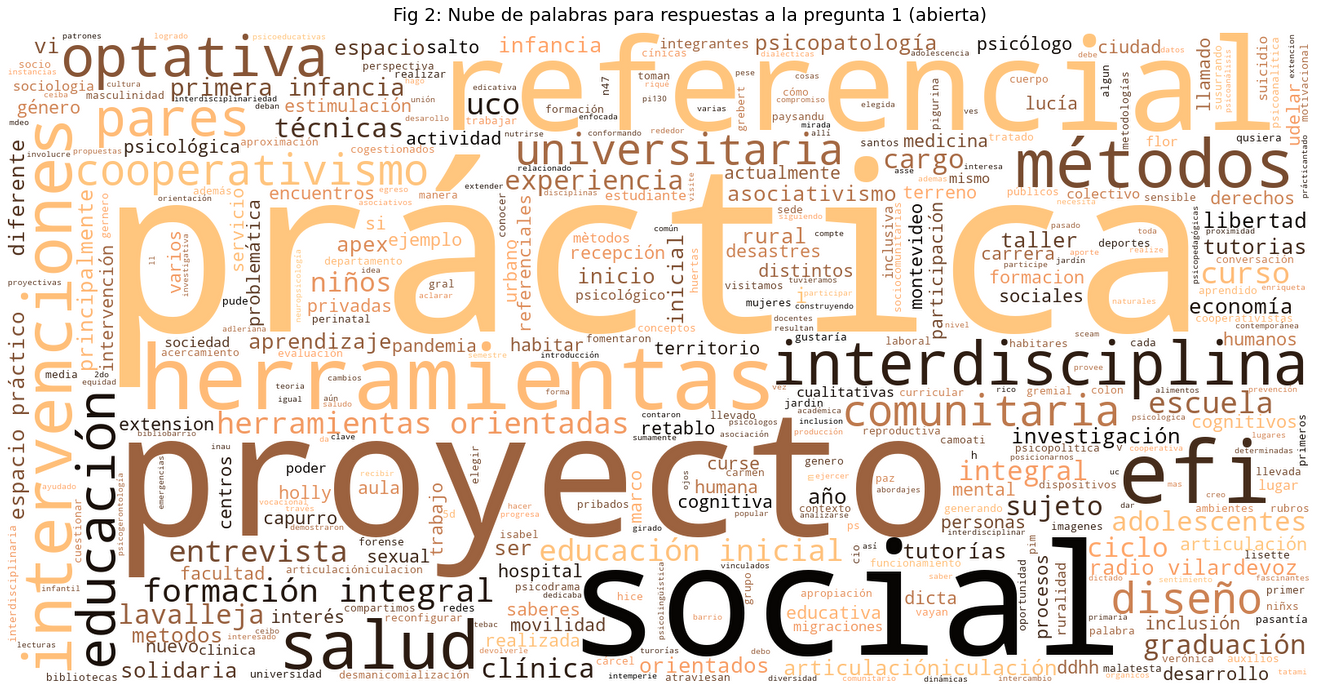

In [18]:
# Follow up to question 1 ("q1_cont"). Since it is an open
# and long answer type of question, that aims to identify the
# courses that have motivated students to find out more about
# outreach, a Wordcloud seems appropiate to properly see
# which courses motivates this. The issue with the answers
# are the spelling variations of a same word, be it because
# of spelling mistakes or using abreviations. So a RegEx
# cleaning is needed for some cases.
re_expression = {
    "[Pp]r[aà]ctica": "práctica",
    "Art": "articulación",
    "[Aa]rticulacion": "articulación",
    "Espacio de Formación Integral": "EFI",
    "[Ee]xtensiòn": "extensión",
    "[Pp]sicologia": "psicología"
    }
working_df["q1_cont"] = working_df["q1_cont"].replace(re_expression, 
                                                      regex = True)
working_df["q1_cont"] = working_df["q1_cont"].str.lower()

# Create a text out of "q1_cont" columns:
q1_cont_s = working_df["q1_cont"].dropna(how = "all").copy()
text = " ".join(answer for answer in q1_cont_s)

# List of stopwords:
stopwords = stopwords.words("spanish")
more_stopwords = ["ii", "club", "psicología", "extensión", "vi", "si",
                  "lucía", "isabel", "holly", "ejemplo", "h", "pude",
                  "udelar"]
stopwords.extend(more_stopwords)

plt.figure(figsize = (24, 12))
wordcloud = (WordCloud(stopwords =  stopwords, background_color = "white",
                       mode = "RGBA", max_words = 1000, colormap = "copper",
                       width=1600, height=800)
             .generate(text)
             )
plt.imshow(wordcloud, interpolation = 'lanczos')
plt.axis("off")
plt.savefig('profex_fig5.png', dpi = 1200, bbox_inches='tight')
plt.show()